In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
gwc = Location(34.2487,-89.8925, 'US/Central', 98, 'Goodwin Creek')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=gwc.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=gwc.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = gwc.get_clearsky(times2009) 
cs_2010and2011 = gwc.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-06:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-06:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-06:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-06:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-06:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Goodwin_Creek\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1029728, 48)

In [18]:
path = r'.\\data\\Goodwin_Creek\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(513149, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(1155, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1029728, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(513149, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1029728, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(987521, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(496347, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

2007

In [32]:
df_train.shape

(987521, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

2206

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(987521, 49)

In [43]:
df_test.shape

(496347, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

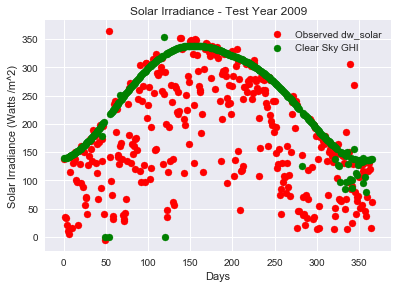

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2a.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


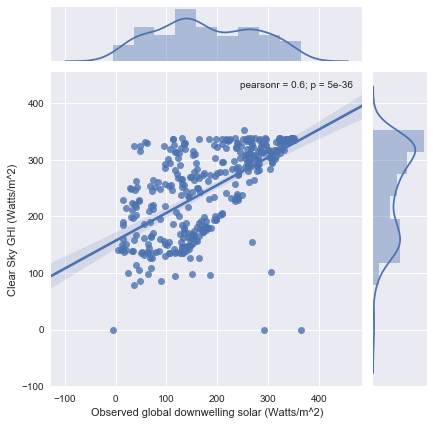

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3a.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 16565.62428392545
test Kt min: -858.197482511317
test Kt mean: 2.3067127385087867


train Kt max: 154389.83695910865
train Kt min: -244.67261793490562
train Kt mean: 3.284695720674705


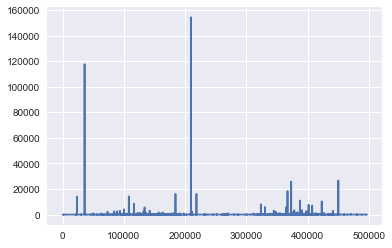

In [50]:
plt.plot(df_train['Kt'])

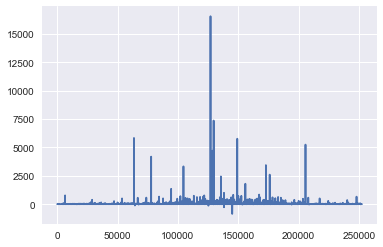

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   157.281154 -4.348077  0.090385  0.150000 -1.123077   
                 8.0   146.229333 -4.288333  0.113333  0.156667 -1.106667   
                 9.0   133.906167 -4.328333  0.178333  0.701667 -1.108333   
                 10.0  121.558667 -4.560000  0.316667 -0.558333 -1.170000   
                 11.0  109.427167 -4.868333  0.553333 -0.383333 -1.276667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   320.623077   280.961538   280.546154  335.715385   
                 8.0   322.270000   280.761667   280.345000  334.833333   
                 9.0   318.151667   280.491667   280.046667  333.480000   
                 10.0  300.935000   279.631667   279.101667  328.243333   
                 11.0  241.326667   277.370000   276.700000  314.453333   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    277.776923    ...          0.0 -15.086538 -15.086538   
                 8.0    277.581667    ...          0.0 -12.571667 -12.571667   
                 9.0    277.301667    ...          0.0 -15.333333 -15.333333   
                 10.0   276.451667    ...          0.0 -27.313333 -27.313333   
                 11.0   274.423333    ...          0.0 -73.125000 -73.125000   

                           temp         rh   windspd     winddir     pressure  \
year   month day hour                                                           
2010.0 1.0   1.0 7.0   5.005769  79.425000  2.300000   69.582692  1013.025000   
                 8.0   4.783333  75.178333  2.541667   84.746667  1013.470000   
                 9.0   4.445000  76.843333  2.831667  159.561667  1013.861667   
                 10.0  3.465000  78.943333  3.700000  133.698333  1014.648333   
                 11.0  1.351667  75.265000  3.646667  135.245000  1015.618333   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 7.0    58.673464 -0.092544  
                 8.0   199.226885 -0.022905  
                 9.0   357.002941 -0.012248  
                 10.0  475.457844 -0.009625  
                 11.0  539.708973 -0.009017  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,156.063125,-5.293750,-0.418750,1.537500,-0.381250,234.900000,272.150000,271.862500,291.925000,272.281250,...,0.000000,-57.043750,-57.043750,0.593750,61.012500,1.137500,116.625000,1013.318750,30.663084,-0.182511
7.0,151.636833,-5.338333,-0.555000,1.555000,-0.473333,235.656667,272.565000,272.235000,291.751667,271.600000,...,0.000000,-56.091667,-56.091667,0.088333,63.146667,0.618333,112.858333,1013.015000,115.766684,-0.058923
8.0,141.881000,-5.150000,-0.876667,0.881667,-0.500000,236.418333,272.275000,271.936667,291.446667,271.781667,...,0.000000,-55.028333,-55.028333,0.830000,57.490000,1.448333,132.271667,1011.976667,310.197139,-0.017190
9.0,130.346167,-5.693333,-0.785000,2.293333,-0.325000,242.050000,272.941667,272.681667,295.341667,273.095000,...,0.000000,-53.295000,-53.295000,1.676667,53.623333,2.033333,137.526667,1011.566667,491.373002,-0.011644
10.0,118.142333,-5.468333,-0.343333,2.310000,-0.261667,293.071667,275.710000,275.516667,308.071667,273.635000,...,0.000000,-16.146667,-16.146667,1.591667,56.341667,1.473333,151.643333,1011.851667,628.392880,-0.008778
11.0,105.758667,-4.468333,-0.058333,1.616667,-0.338333,321.446667,277.086667,276.876667,315.970000,273.856667,...,0.000000,0.000000,0.000000,1.773333,59.400000,0.791667,162.733333,1012.278333,707.999345,-0.006309
12.0,93.360000,-5.085000,0.435000,0.523333,0.573333,324.706667,277.511667,277.048333,318.663333,274.298333,...,0.543333,0.000000,0.543333,2.150000,62.286667,1.993333,152.851667,1012.153333,723.565963,-0.007017
13.0,81.477500,10.581667,3.041667,0.323333,15.745000,326.311667,277.568333,277.051667,320.978333,274.485000,...,12.793333,0.000000,12.793333,2.198333,71.641667,2.133333,160.955000,1012.345000,673.851495,0.015885
14.0,70.368167,44.298333,7.703333,1.603333,47.981667,327.441667,277.428333,276.891667,323.908333,274.638333,...,40.848333,-0.015000,40.835000,2.188333,82.856667,2.678333,166.960000,1012.361667,562.891372,0.082049


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-2)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-2)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
7.0,31.0,18.0,17.352667,804.265,143.933333,474.62,338.386667,422.245,308.041667,307.96,482.356667,303.85,...,646.77,-60.106667,586.668333,28.04,64.46,1.555,260.845,1005.741667,213.182009,1801.872849


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9000, 22)
y1_train shape is (9000,)
X2_test shape is (3900, 22)
y2_test shape is (3900,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
       
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
        n_iter += 1       

Epoch: 0 Iteration: 0. Train_MSE: 0.07102621346712112. Test_MSE: 0.002616565671594597
Epoch: 1 Iteration: 100. Train_MSE: 0.04818740859627724. Test_MSE: 0.0017127833451811853
Epoch: 2 Iteration: 200. Train_MSE: 0.032102301716804504. Test_MSE: 0.0010895137739285131
Epoch: 3 Iteration: 300. Train_MSE: 0.015069985762238503. Test_MSE: 0.0006701087734201043
Epoch: 4 Iteration: 400. Train_MSE: 0.001872098888270557. Test_MSE: 0.00042209753473087755
Epoch: 5 Iteration: 500. Train_MSE: 0.003314315341413021. Test_MSE: 0.0002986154289320017
Epoch: 6 Iteration: 600. Train_MSE: 0.007565425243228674. Test_MSE: 0.00027366245757225345
Epoch: 7 Iteration: 700. Train_MSE: 0.0017244565533474088. Test_MSE: 0.00030086124995269887
Epoch: 8 Iteration: 800. Train_MSE: 0.0004533612809609622. Test_MSE: 0.00033080792318494696
Epoch: 10 Iteration: 900. Train_MSE: 0.0023514230269938707. Test_MSE: 0.00035154160463967196
Epoch: 11 Iteration: 1000. Train_MSE: 0.0044293953105807304. Test_MSE: 0.00037339692407983225
Ep

Epoch: 101 Iteration: 9000. Train_MSE: 0.00027039804263040423. Test_MSE: 0.0002738220768785274
Epoch: 102 Iteration: 9100. Train_MSE: 0.0007372400723397732. Test_MSE: 0.000273459988002357
Epoch: 103 Iteration: 9200. Train_MSE: 0.0005497653619386256. Test_MSE: 0.00027373653760794976
Epoch: 104 Iteration: 9300. Train_MSE: 0.000511855585500598. Test_MSE: 0.0002721888599591102
Epoch: 105 Iteration: 9400. Train_MSE: 0.0005754136363975704. Test_MSE: 0.00027162687531975344
Epoch: 106 Iteration: 9500. Train_MSE: 0.0010389707749709487. Test_MSE: 0.0002712090164594662
Epoch: 107 Iteration: 9600. Train_MSE: 0.0005902088014408946. Test_MSE: 0.00027107776665497593
Epoch: 108 Iteration: 9700. Train_MSE: 0.000554964761249721. Test_MSE: 0.0002707857240461164
Epoch: 110 Iteration: 9800. Train_MSE: 0.0005419874214567244. Test_MSE: 0.00026942382198095
Epoch: 111 Iteration: 9900. Train_MSE: 0.0008617540588602424. Test_MSE: 0.00026901384077881064
Epoch: 112 Iteration: 10000. Train_MSE: 0.001013958360999822

Epoch: 197 Iteration: 17600. Train_MSE: 0.0007237786194309592. Test_MSE: 0.0002381522288813406
Epoch: 198 Iteration: 17700. Train_MSE: 0.0004133535549044609. Test_MSE: 0.0002379265009284767
Epoch: 200 Iteration: 17800. Train_MSE: 0.0007750818622298539. Test_MSE: 0.00023800919034853215
Epoch: 201 Iteration: 17900. Train_MSE: 0.00017503215349279344. Test_MSE: 0.00023717441349410833
Epoch: 202 Iteration: 18000. Train_MSE: 0.0006250643637031317. Test_MSE: 0.00023685871425823825
Epoch: 203 Iteration: 18100. Train_MSE: 0.00039197865407913923. Test_MSE: 0.00023691862834323074
Epoch: 204 Iteration: 18200. Train_MSE: 0.0004452329012565315. Test_MSE: 0.0002361434483365631
Epoch: 205 Iteration: 18300. Train_MSE: 0.00041164804133586586. Test_MSE: 0.00023590976708761795
Epoch: 206 Iteration: 18400. Train_MSE: 0.0008791125728748739. Test_MSE: 0.00023560830863826398
Epoch: 207 Iteration: 18500. Train_MSE: 0.00043885334162041545. Test_MSE: 0.00023544330202728288
Epoch: 208 Iteration: 18600. Train_MSE:

Epoch: 294 Iteration: 26200. Train_MSE: 0.00040216362685896456. Test_MSE: 0.00021476980493773164
Epoch: 295 Iteration: 26300. Train_MSE: 0.0011077290400862694. Test_MSE: 0.00021418591927481722
Epoch: 296 Iteration: 26400. Train_MSE: 0.00037953307037241757. Test_MSE: 0.00021404185944881685
Epoch: 297 Iteration: 26500. Train_MSE: 0.0006625734968110919. Test_MSE: 0.00021384258947727334
Epoch: 298 Iteration: 26600. Train_MSE: 0.0003597511094994843. Test_MSE: 0.0002136495210500817
Epoch: 300 Iteration: 26700. Train_MSE: 0.0007128105498850346. Test_MSE: 0.00021372562549293
Epoch: 301 Iteration: 26800. Train_MSE: 0.000139163137646392. Test_MSE: 0.00021314589632918238
Epoch: 302 Iteration: 26900. Train_MSE: 0.0005733567522838712. Test_MSE: 0.0002128932460692584
Epoch: 303 Iteration: 27000. Train_MSE: 0.00032864109380170703. Test_MSE: 0.00021291043997922023
Epoch: 304 Iteration: 27100. Train_MSE: 0.0003847041225526482. Test_MSE: 0.0002123595672103405
Epoch: 305 Iteration: 27200. Train_MSE: 0.00

Epoch: 391 Iteration: 34800. Train_MSE: 0.00037406408227980137. Test_MSE: 0.0001967783071506456
Epoch: 392 Iteration: 34900. Train_MSE: 0.00038693618262186646. Test_MSE: 0.00019630072845282568
Epoch: 393 Iteration: 35000. Train_MSE: 0.0009137842571362853. Test_MSE: 0.00019612638617285565
Epoch: 394 Iteration: 35100. Train_MSE: 0.0003540042380336672. Test_MSE: 0.0001961124284672935
Epoch: 395 Iteration: 35200. Train_MSE: 0.000957963929977268. Test_MSE: 0.00019565362082629218
Epoch: 396 Iteration: 35300. Train_MSE: 0.0003190386341884732. Test_MSE: 0.000195547432801098
Epoch: 397 Iteration: 35400. Train_MSE: 0.0006254275795072317. Test_MSE: 0.00019539721956250076
Epoch: 398 Iteration: 35500. Train_MSE: 0.00032055587507784367. Test_MSE: 0.0001952334747448042
Epoch: 400 Iteration: 35600. Train_MSE: 0.0006533071864396334. Test_MSE: 0.0001952971098054992
Epoch: 401 Iteration: 35700. Train_MSE: 0.00011803409142885357. Test_MSE: 0.00019485500351938868
Epoch: 402 Iteration: 35800. Train_MSE: 0.0

Epoch: 487 Iteration: 43400. Train_MSE: 0.00017507215670775622. Test_MSE: 0.000181918331365943
Epoch: 488 Iteration: 43500. Train_MSE: 0.0009807791793718934. Test_MSE: 0.00018181912377679535
Epoch: 489 Iteration: 43600. Train_MSE: 0.00015361847181338817. Test_MSE: 0.00018168086834689207
Epoch: 491 Iteration: 43700. Train_MSE: 0.0003273342445027083. Test_MSE: 0.00018171867863545356
Epoch: 492 Iteration: 43800. Train_MSE: 0.0003314425121061504. Test_MSE: 0.00018133640478084896
Epoch: 493 Iteration: 43900. Train_MSE: 0.0008989410707727075. Test_MSE: 0.0001811882060947146
Epoch: 494 Iteration: 44000. Train_MSE: 0.0003163327928632498. Test_MSE: 0.0001811729993751487
Epoch: 495 Iteration: 44100. Train_MSE: 0.0008406923734582961. Test_MSE: 0.00018078921396493403
Epoch: 496 Iteration: 44200. Train_MSE: 0.0002758572227321565. Test_MSE: 0.00018070649495008164
Epoch: 497 Iteration: 44300. Train_MSE: 0.0005983827286399901. Test_MSE: 0.00018058958430062998
Epoch: 498 Iteration: 44400. Train_MSE: 0.

Epoch: 584 Iteration: 52000. Train_MSE: 0.0011918277014046907. Test_MSE: 0.0001697457319844509
Epoch: 585 Iteration: 52100. Train_MSE: 0.00020420076907612383. Test_MSE: 0.00016968087133226298
Epoch: 586 Iteration: 52200. Train_MSE: 0.0001427690003765747. Test_MSE: 0.00016939044739549557
Epoch: 587 Iteration: 52300. Train_MSE: 0.00015577532758470625. Test_MSE: 0.0001693099615527244
Epoch: 588 Iteration: 52400. Train_MSE: 0.0009606513194739819. Test_MSE: 0.00016922986737652476
Epoch: 589 Iteration: 52500. Train_MSE: 0.0001423556386725977. Test_MSE: 0.00016911004221053795
Epoch: 591 Iteration: 52600. Train_MSE: 0.00028939370531588793. Test_MSE: 0.00016914318732569057
Epoch: 592 Iteration: 52700. Train_MSE: 0.0002892641059588641. Test_MSE: 0.00016882538834331922
Epoch: 593 Iteration: 52800. Train_MSE: 0.0008895839564502239. Test_MSE: 0.0001686982314685773
Epoch: 594 Iteration: 52900. Train_MSE: 0.00028481296612881124. Test_MSE: 0.00016868570412957815
Epoch: 595 Iteration: 53000. Train_MSE:

Epoch: 680 Iteration: 60600. Train_MSE: 0.0002291351556777954. Test_MSE: 0.00015934663183585554
Epoch: 682 Iteration: 60700. Train_MSE: 0.00037424280890263617. Test_MSE: 0.0001593520552788226
Epoch: 683 Iteration: 60800. Train_MSE: 0.0002602623717393726. Test_MSE: 0.00015909210076710018
Epoch: 684 Iteration: 60900. Train_MSE: 0.0011749276891350746. Test_MSE: 0.00015901756188881863
Epoch: 685 Iteration: 61000. Train_MSE: 0.00018273830937687308. Test_MSE: 0.0001589627371260972
Epoch: 686 Iteration: 61100. Train_MSE: 0.00012805509322788566. Test_MSE: 0.00015870338276557336
Epoch: 687 Iteration: 61200. Train_MSE: 0.0001399282191414386. Test_MSE: 0.00015864141198389744
Epoch: 688 Iteration: 61300. Train_MSE: 0.0009448184864595532. Test_MSE: 0.0001585779538487158
Epoch: 689 Iteration: 61400. Train_MSE: 0.0001333133695879951. Test_MSE: 0.00015847426111702056
Epoch: 691 Iteration: 61500. Train_MSE: 0.00025812923558987677. Test_MSE: 0.0001585072943054425
Epoch: 692 Iteration: 61600. Train_MSE: 

Epoch: 777 Iteration: 69200. Train_MSE: 0.0002703395439311862. Test_MSE: 0.00015027857197966743
Epoch: 778 Iteration: 69300. Train_MSE: 0.000144889549119398. Test_MSE: 0.00015024097996017087
Epoch: 779 Iteration: 69400. Train_MSE: 0.0010355138219892979. Test_MSE: 0.00015018902863348676
Epoch: 780 Iteration: 69500. Train_MSE: 0.0002074610092677176. Test_MSE: 0.00015008988213797937
Epoch: 782 Iteration: 69600. Train_MSE: 0.00033813592744991183. Test_MSE: 0.00015009784836875044
Epoch: 783 Iteration: 69700. Train_MSE: 0.00023551312915515155. Test_MSE: 0.00014987354423870602
Epoch: 784 Iteration: 69800. Train_MSE: 0.0011605990584939718. Test_MSE: 0.0001498102629440649
Epoch: 785 Iteration: 69900. Train_MSE: 0.00016508260159753263. Test_MSE: 0.00014976307997315198
Epoch: 786 Iteration: 70000. Train_MSE: 0.00011614998220466077. Test_MSE: 0.00014952649844526697
Epoch: 787 Iteration: 70100. Train_MSE: 0.00012649722339119762. Test_MSE: 0.00014947915018712372
Epoch: 788 Iteration: 70200. Train_MS

Epoch: 874 Iteration: 77800. Train_MSE: 0.00015666353283450007. Test_MSE: 0.00014257571865762664
Epoch: 875 Iteration: 77900. Train_MSE: 0.0131159583106637. Test_MSE: 0.00014245547002392534
Epoch: 876 Iteration: 78000. Train_MSE: 0.0002111602370860055. Test_MSE: 0.00014242301647882997
Epoch: 877 Iteration: 78100. Train_MSE: 0.00024273259623441845. Test_MSE: 0.0001422292821990323
Epoch: 878 Iteration: 78200. Train_MSE: 0.0001292571978410706. Test_MSE: 0.00014220403136425857
Epoch: 879 Iteration: 78300. Train_MSE: 0.0010250372579321265. Test_MSE: 0.0001421605339336587
Epoch: 880 Iteration: 78400. Train_MSE: 0.00018905433535110205. Test_MSE: 0.00014207232122536904
Epoch: 882 Iteration: 78500. Train_MSE: 0.0003080404130741954. Test_MSE: 0.00014208107269791085
Epoch: 883 Iteration: 78600. Train_MSE: 0.0002146053739124909. Test_MSE: 0.00014188656954165898
Epoch: 884 Iteration: 78700. Train_MSE: 0.0011481449473649263. Test_MSE: 0.0001418316949200183
Epoch: 885 Iteration: 78800. Train_MSE: 0.0

Epoch: 970 Iteration: 86400. Train_MSE: 0.008298207074403763. Test_MSE: 0.00013570554008543491
Epoch: 971 Iteration: 86500. Train_MSE: 0.0001750295195961371. Test_MSE: 0.00013564063756372688
Epoch: 973 Iteration: 86600. Train_MSE: 0.00011672219989122823. Test_MSE: 0.0001356910273064918
Epoch: 974 Iteration: 86700. Train_MSE: 0.000146513368235901. Test_MSE: 0.0001355193059871635
Epoch: 975 Iteration: 86800. Train_MSE: 0.013096796348690987. Test_MSE: 0.00013540686344920482
Epoch: 976 Iteration: 86900. Train_MSE: 0.00018971574900206178. Test_MSE: 0.00013538334978053783
Epoch: 977 Iteration: 87000. Train_MSE: 0.00021997712610755116. Test_MSE: 0.00013520466054886567
Epoch: 978 Iteration: 87100. Train_MSE: 0.00011683462798828259. Test_MSE: 0.00013518989067916117
Epoch: 979 Iteration: 87200. Train_MSE: 0.001015855697914958. Test_MSE: 0.00013515409545484253
Epoch: 980 Iteration: 87300. Train_MSE: 0.00017377789481543005. Test_MSE: 0.0001350754861392037
Epoch: 982 Iteration: 87400. Train_MSE: 0.

33820


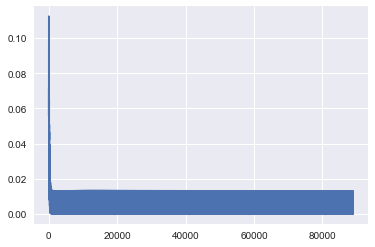

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


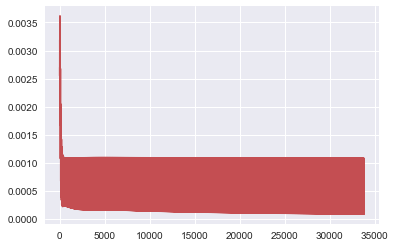

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

26.801033625268513

In [83]:
df_new_test['Kt'].describe()

count    3846.000000
mean        5.949008
std        38.282310
min        -0.038391
25%        -0.007695
50%         0.195282
75%         1.414407
max      1801.872849
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss,'iteration':train_iter}, columns=['Train Loss','iteration'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_GoodwinCreek_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss,'iteration':test_iter}, columns=['Test Loss','iteration'])
df_testLoss.to_csv('RNN Paper Results/Exp1_GoodwinCreek_TestLoss.csv')